<a href="https://colab.research.google.com/github/gmanfunkflex5500/nyc_taxi_filter/blob/master/Airport_Report_2018_jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
This project uses the Google Cloud Platform to perform an analysis on NYC's documented 
shared rides from 2018. 

The Goal of this project is to create an analysis that counts the number of 
wheelchair accessible (WAV), battery electric (BEV), and shared ride trips from 
New York's three airports for the week of Jan 8th-15th, 2018. 

This analysis will include comparisons of each major ride share company (Uber, Lyft, Juno) 
to each other as well as to the rest of the industry, as well as include daily aggregates.

This project will be used to produce a 1-page summary document of the findings, 
methodology, and limitations of this analysis.

Pickup location id's are taken from 
https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc

The id's are:
EWR = 1 
LGA = 138
JFK = 132

Data is from NYC Open Data https://data.cityofnewyork.us/Transportation/2018-For-Hire-Vehicles-Trip-Data/am94-epxh/

For future data keeping I would recommend tracking the first 8 digits of a 
vehicle's VIN number to rides, as those are not linked to models instead of 
individual cars. This will provide anonymity for drivers while increasing the 
accuracy of the data available by providing care make and model or each ride.

Additional note - the links in the project guidelines often have inappropriate spaces 
that redirect to an incomplete URL.
```



In [285]:
# Connect to google drive to access data and sensitive info

from google.colab import drive

drive.mount('/content/drive')#/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [286]:
!ls "/content/drive/My Drive/Colab Notebooks/NYC airport trips jan 2018"

'Airport Report 2018-jan.ipynb'   config.json
 api_keys.json			  data_dictionary_trip_records_fhv.pdf
 config.js			  keys.json


In [0]:
# load config.json that contains sensitive login information
with open('/content/drive/My Drive/Colab Notebooks/NYC airport trips jan 2018/config.json', 'r') as f:
  keyload = f.read()
  f.close()

keys = json.loads(keyload)['config']


In [257]:
# J. Garrett Frierson - Nov. 4th, 2019 - Brooklyn, NY
!pip install sodapy
!pip install bs4

In [0]:
# Importing relevant libraries

from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import requests
import json



#**IMPORTING DATA**




### Import the trip data

In [33]:
# Importing trip data using NYC Open Data user info

client = Socrata("data.cityofnewyork.us", 
                 keys['APP_TOKEN'],
                 username=key['username'],
                 password= keys["pwd"])

#results = client.get_metadata("am94-epxh")
results = client.get("am94-epxh", 
                     where="pickup_datetime between '2018-01-08T00:00:00.000' and '2018-01-16T00:00:00.000' AND pulocationid in (138, 132, 1)", 
                     limit=50000000)
len(results)

125542

### Import the vehicle data

In [5]:
# Importing vehicle info by dispatcher to approximate the total number of WAV and BEV
# taken from https://data.cityofnewyork.us/Transportation/For-Hire-Vehicles-FHV-Active/8wbx-tsch/data
query = """
SELECT 
base_number, wheelchair_accessible, vehicle_vin_number
GROUP BY base_number, wheelchair_accessible, vehicle_vin_number
LIMIT 500000
"""

vehicle_client = Socrata("data.cityofnewyork.us", 
                 keys['APP_TOKEN'],
                 username=key['username'],
                 password= keys["pwd"])

#results = client.get_metadata("am94-epxh")
vehicle_results = client.get("8wbx-tsch", query=query)
                             #select="base_number, wheelchair_accessible",
                             #where= "vehicle_year < 2019 AND veh IS NOT NULL",#"wheelchair_accessible IS NOT NULL",
                             #limit=10)
vehicle_results

[{'base_number': 'B03179', 'vehicle_vin_number': '1GNSKJKC6FR194528'},
 {'base_number': 'B01510', 'vehicle_vin_number': '1FADP5AU8EL507476'},
 {'base_number': 'B02990', 'vehicle_vin_number': '1GNSKHKC2JR143562'},
 {'base_number': 'B02682', 'vehicle_vin_number': 'JTMBFREV1HJ119942'},
 {'base_number': 'B02869', 'vehicle_vin_number': '1HGCR2F32EA175241'},
 {'base_number': 'B02682', 'vehicle_vin_number': '4T1BF1FKXHU411847'},
 {'base_number': 'B02870', 'vehicle_vin_number': '5TDJZRFH0HS378291'},
 {'base_number': 'B02887', 'vehicle_vin_number': '4T1BF1FK2GU214637'},
 {'base_number': 'B02880', 'vehicle_vin_number': '1N4AL3AP7DN581939'},
 {'base_number': 'B02879', 'vehicle_vin_number': '2HKRW2H87JH616777'},
 {'base_number': 'B02872', 'vehicle_vin_number': '1FADP3K28FL363124'},
 {'base_number': 'B02970', 'vehicle_vin_number': '2C3CCAGG5FH854083'},
 {'base_number': 'B02884', 'vehicle_vin_number': '1C4RJFAG0CC128728'},
 {'base_number': 'B01315', 'vehicle_vin_number': '5TDJKRFH9GS253373'},
 {'bas

## Clean the vehicle data 
and implement counts of WAV and BEV's

Count all WAVs from our database

In [6]:
# Create a dataframe of our vehicles and make WAV either a 1 (WAV) or 0 (not)

vh_df = pd.DataFrame(data=vehicle_results)
vh_df = vh_df.fillna(0)
vh_df['wheelchair_accessible'] = vh_df['wheelchair_accessible'].replace('WAV', 1)
vh_df.describe()

,wheelchair_accessible
count,115845.000000
mean,0.011015
std,0.104372
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [7]:
# Some dispatchers do not have a vehicle associated in this database
vh_df.loc[vh_df['base_number'] == 'B00236']

,base_number,vehicle_vin_number,wheelchair_accessible


Remove single vehicle identifiers to focus only on make and models

In [0]:
# The last 8 numbers of a vehicles vin number relate to the year and factory they were made in 
# and individual vehicle identificaiton. 
# The first 8 numbers describe the vehicle model and details.
# We are only keeping the first 8 digits so we can group cars by make and model

vh_df['vehicle_vin_number'] = vh_df['vehicle_vin_number'].str[:8]

In [9]:
# Adding a single value for each vehicle to be summed when grouping, giving us the count
# of each vehicle in each dispatcher's fleet.
vh_df['vehicle_count'] = 1
vh_df['vehicle_count']

0         1
1         1
2         1
3         1
4         1
         ..
115840    1
115841    1
115842    1
115843    1
115844    1
Name: vehicle_count, Length: 115845, dtype: int64

In [10]:
# Grouping our vehicles by base number and vin number (make model)
vh_grouped_df = vh_df.groupby(['base_number','vehicle_vin_number']).sum()
vh_grouped_df


wheelchair_accessible  vehicle_count
base_number vehicle_vin_number                                      
B00001      1GYS4GKJ                                0              2
            1GYS4HKJ                                0              2
            2G61U5S3                                0             16
            3FADP0L3                                0              1
            WBA7E4C5                                0              4
...                                               ...            ...
B03258      5TDKZ3DC                                0              2
            5TDYK3DC                                0              2
            5TDYZ3DC                                0              1
            NJ040D                                  0              1
B90139      1FTYR2CM                                0              1

[26319 rows x 2 columns]

### Create a dataframe of vehicle fuel types

In [0]:
# Pull out distinct vehicle types to send to nhtsa.dot.gov api to get vehicle details
# API connection at https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVinValues/

import ast

def vehicle_details_retriever(model):
  vh_dict = {}
  url1 = 'https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVinValues/'
  url2 = '?format=json'

  
  api_connect = url1 + model + url2;    # Create our api url to pull vehicle details
  r2 = requests.get(api_connect);      # Connect to api and retrieve details
  r2.json()                     # parse into json
  u = json.dumps(r2.json()['Results'])
  # Create dict of vehicle details
  dict_u = ast.literal_eval(u.replace("[","").replace("]","")) 
  if 'FuelTypePrimary' in dict_u:
    x,y = dict_u['FuelTypePrimary'], dict_u['FuelTypeSecondary']
  #  print(model, (x,y))    # uncomment for debugging 
    vh_dict[model] = (x,y)
  else:
  #  print('NA')            # uncomment for debugging 
    vh_dict[model] = ('None', 'None')

  return vh_dict
  
  



In [12]:
from multiprocessing import Pool  # multiprocessing used to speed up this api query

with Pool(50) as p:
  vh_dict_list = p.map(vehicle_details_retriever,vh_df['vehicle_vin_number'].unique())

vh_dict_list

[{'1GNSKJKC': ('Gasoline', 'Ethanol (E85)')},
 {'1FADP5AU': ('Gasoline', 'Electric')},
 {'1GNSKHKC': ('Gasoline', 'Ethanol (E85)')},
 {'JTMBFREV': ('Gasoline', '')},
 {'1HGCR2F3': ('Gasoline', '')},
 {'4T1BF1FK': ('Gasoline', '')},
 {'5TDJZRFH': ('Gasoline', '')},
 {'1N4AL3AP': ('Gasoline', '')},
 {'2HKRW2H8': ('Gasoline', '')},
 {'1FADP3K2': ('Gasoline', 'Flexible Fuel Vehicle (FFV)')},
 {'2C3CCAGG': ('Gasoline', '')},
 {'1C4RJFAG': ('Gasoline', 'Ethanol (E85)')},
 {'5TDJKRFH': ('Gasoline', '')},
 {'1GKKVTED': ('Gasoline', '')},
 {'5XXGM4A7': ('Gasoline', '')},
 {'1LNHM81W': ('Gasoline', '')},
 {'5NPE24AF': ('Gasoline', '')},
 {'WD4PG2EE': ('Gasoline', '')},
 {'4T4BF1FK': ('Gasoline', '')},
 {'4T1BD1FK': ('Gasoline', 'Electric')},
 {'3GYFNEE3': ('Gasoline', 'Ethanol (E85)')},
 {'5J6RM4H3': ('Gasoline', '')},
 {'5TDZK3DC': ('Gasoline', '')},
 {'4T4BF3EK': ('Gasoline', '')},
 {'2GNFLEEK': ('Gasoline', 'Ethanol (E85)')},
 {'2T3BFREV': ('Gasoline', '')},
 {'2LNHM82W': ('Gasoline', '')},
 

In [13]:
# Confirm our list of vehicles is the same number as our car values
print(len(vh_dict_list), len(vh_df['vehicle_vin_number'].unique()))


2544 2544


In [14]:
# Convert our vehicle info into a dataframe
vh_dict = {}
for vh in vh_dict_list:
  vh_dict.update(vh)


vh_dts_df = pd.DataFrame.from_dict(vh_dict, orient='index', columns=['fuel_type_1', 'fuel_type_2'])
vh_dts_df.sample(10)


,fuel_type_1,fuel_type_2
1FMEU62E,Gasoline,
4A4AP4AU,Gasoline,
2HNYD286,Gasoline,
1V2PR2CA,Gasoline,
JH4KC1F5,Gasoline,
JN1BJ0RP,Gasoline,
1GNKVGKD,Gasoline,
4S4BRBAC,Gasoline,
1G1105SA,Gasoline,Ethanol (E85)
3GNAXUEV,Gasoline,


Edit our dataframe to focus solely on if a vehicle is a BEV

In [15]:
# Count the number of electric only vehicle types
vh_dts_df.loc[(vh_dts_df['fuel_type_1'] == 'Electric') & (vh_dts_df['fuel_type_2'] == '')].count()

fuel_type_1    26
fuel_type_2    26
dtype: int64

In [16]:
# Create a field that demarks if vehicle is BEV or no (0 = no, 1 = yes)
vh_dts_df['BEV'] = 0
vh_dts_df['BEV'].loc[(vh_dts_df['fuel_type_1'] == 'Electric') & (vh_dts_df['fuel_type_2'] == '')] = 1
vh_dts_df['BEV'].sum()  # Check that we hav the right amount of vehicles

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


26

In [17]:
bev_df = vh_dts_df.drop(['fuel_type_1', 'fuel_type_2'], axis=1).rename_axis('vehicle_vin_number')
bev_df.head()

,BEV
vehicle_vin_number,
1GNSKJKC,0
1FADP5AU,0
1GNSKHKC,0
JTMBFREV,0
1HGCR2F3,0


Combining BEV with our grouped vehicle dataframe


In [18]:
# Join our BEV column onto our table with other details for vehicle info

vh_fnl = vh_grouped_df.join(bev_df, 
                            how='left')  
# Multiplying BEV by vehicle count to accurately depict the total number of BEV's in 
# each fleet, similar to wheelchair accessible vehicles
vh_fnl['BEV'] = vh_fnl['BEV'] * vh_fnl['vehicle_count']
vh_fnl.loc[vh_fnl['BEV'] != 0]

wheelchair_accessible  vehicle_count  BEV
base_number vehicle_vin_number                                           
B00472      5YJSA1CN                                0              2    2
B00789      5YJXCAE2                                0              1    1
B01509      1G1ZB5E0                                0              1    1
B01899      5YJ3E1EA                                0              1    1
B02152      5YJ3E1EB                                0              1    1
...                                               ...            ...  ...
B03136      5YJ3E1EB                                0              4    4
            5YJSA1E2                                0              1    1
B03138      5YJSA1H1                                0              1    1
B03146      5YJXCBE2                                0              1    1
B03147      5YJ3E1EA                                0              1    1

[62 rows x 3 columns]

Create a table of dispatchers, with the probability of any given trip being a WAV or BEV

In [19]:
# Create a table of dispatchers with probability scores 
# for any given ride to be a WAV or BEV

dsptch_scores = vh_fnl.reset_index().drop('vehicle_vin_number', axis=1).groupby('base_number').sum()
dsptch_scores['BEV_Prob'] = (dsptch_scores['BEV'] / dsptch_scores['vehicle_count'])
dsptch_scores['WAV_Prob'] = (dsptch_scores['wheelchair_accessible'] / dsptch_scores['vehicle_count'])
dsptch_scores = dsptch_scores.drop(['wheelchair_accessible','vehicle_count', 'BEV'], axis=1)
dsptch_scores.describe()

,BEV_Prob,WAV_Prob
count,912.000000,912.000000
mean,0.000718,0.019041
std,0.006856,0.086085
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,0.125000,1.000000


In [0]:
dsptch_scores = dsptch_scores.rename_axis('dispatching_base_num')

# Cleaning trip data

In [34]:
# Converting data to dataframe

results_df = pd.DataFrame.from_records(results)

results_df.head()




,dispatching_base_num,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,sr_flag
0,B00823,2018-01-08T00:00:00.000,2018-01-08T00:33:52.000,138,25,NaN
1,B00823,2018-01-08T00:00:00.000,2018-01-08T01:45:58.000,132,181,NaN
2,B02835,2018-01-08T00:00:03.000,2018-01-08T00:16:22.000,138,65,NaN
3,B02510,2018-01-08T00:00:10.000,2018-01-08T03:06:32.000,138,265,NaN
4,B02867,2018-01-08T00:00:10.000,2018-01-08T00:30:42.000,132,164,NaN


In [35]:
# Checking to make sure our dates as well as locations are properly filtered
print(results_df['pickup_datetime'].min(), results_df['pickup_datetime'].max(), "Locations = " + results_df.pulocationid.unique())

2018-01-08T00:00:00.000 2018-01-15T23:59:48.000 ['Locations = 138' 'Locations = 132' 'Locations = 1']


In [36]:
# Checking for null values
results_df.isna().any()

dispatching_base_num    False
pickup_datetime         False
dropoff_datetime        False
pulocationid            False
dolocationid             True
sr_flag                  True
dtype: bool

In [0]:
# Removing dolocationid as it is not relevant to this analysis
df_no_nan = results_df.drop('dolocationid', axis=1)
# Replacing NaN's with 0 for sr_flag (sharing indicator, 1 = shared, 0 = not shared)
df_no_nan = df_no_nan.fillna(0)

## Creating a table of dispatchers
scraped from http://www.nybcf.org/members 


In [0]:

# Finding the dispatching base number for our cars using Beautiful Soup to scrape 
# http://www.nybcf.org/members 
from bs4 import BeautifulSoup as BS

url = 'http://www.nybcf.org/members'
r = requests.get(url)
soup = BS(r.content, 'html.parser')
#print(soup.prettify)  # uncomment to see html output

In [0]:
# Function to convert list of strings taken from html page to a dictionary of dispacting base numbers
def make_dispatch_dict(lst):
  new_dict = {lst[i][:6] : lst[i][7:] for i in range(0, len(lst))}
  return new_dict

  # Some companies are registered with multiple dispatch number and multiple company names
# Here I Define a function to consolidate multiple business names to be easily identified
def company_consolidator(comp_dict, app, other=False):
  new_dict = comp_dict
  for key, value in new_dict.items():
    for i in range(len(app)):
      if app[i] in value:
        new_dict[key] = app[i]
        
      
      if other == True:               # optional for creating list with 'other' as
                              # any company not in the big 4
        if new_dict[key] in app:          
          pass
        
        else: 
          new_dict[key] = 'other'

  return new_dict



In [90]:
 #'B02617': 'Weiter, LLC.(Uber)',


a = ['Uber', 'Lyft']
'SS Limousine Service, Inc.' in a

False

In [82]:
# Use Regex and string replacement to pull just the dispatch numbers and names

import re

companies = soup.find_all(string=re.compile("B0"))
companies_list = [i.replace('\n','').lstrip() for i in companies]

companies_list[:5]

['B02160 12th Street Luxury Cars, Inc.',
 'B03135 28 Express Inc. ',
 'B03063 786 Transportation Rides, Inc. ',
 'B02834 811 Transit Corp.',
 'B03159 A1 Accessible Transportation LLC ']

In [102]:
# make a new dict, keys are the dispatch number and values are the company name
dispatch_dict = make_dispatch_dict(companies_list)
dispatch_dict

{'B00000': "Matthew's Limo Inc. ",
 'B00013': 'Love Corporate Car, Inc.',
 'B00014': 'N.Y. One Corporate Car, Inc.',
 'B00053': 'Charge & Ride, Inc.',
 'B00084': 'Automotive Service Systems, Inc.',
 'B00111': 'Skyline Credit Ride, Inc.',
 'B00202': 'Excelsior Car & Limo.',
 'B00208': 'Ernest Schwarz, Inc.',
 'B00227': 'Park West Executive Services d/b/a Town Car',
 'B00235': 'Aristacar & Limousine Ltd.',
 'B00236': 'Last Radio Group',
 'B00254': 'X Y Z Two Way Radio Service, Inc.',
 'B00271': 'UTOG 2-Way Radio, Inc.',
 'B00272': 'Big Apple Car, Inc.',
 'B00277': 'All City Corporate Transportation, Inc.',
 'B00280': 'Fleet Radio Dispatch Corporation d/b/a MinuteMen',
 'B00296': 'Prime Time Transportation, Inc.',
 'B00306': 'Love Limousine NYC Ltd.',
 'B00381': 'Bell Radio, Inc.',
 'B00411': 'Fone-A-Car, Inc.',
 'B00412': 'NYC 2 Way International Ltd.',
 'B00446': 'Communicar, Inc.',
 'B00477': 'Inta-Boro Acres, Inc.',
 'B00552': 'Hinomaru Enterprises, Inc.',
 'B00608': 'Summit Corporate

In [104]:
# The custom function company_consolidator replaces any 
# company names that aren't uniform with a uniform company name for each app

app_list = ['Uber','Lyft','Juno','Via']
consolidated_dispatchers = company_consolidator(dispatch_dict, app_list, other=True)
consolidated_dispatchers_all = company_consolidator(dispatch_dict, app_list)

consolidated_dispatchers

{'B00000': 'other',
 'B00013': 'other',
 'B00014': 'other',
 'B00053': 'other',
 'B00084': 'other',
 'B00111': 'other',
 'B00202': 'other',
 'B00208': 'other',
 'B00227': 'other',
 'B00235': 'other',
 'B00236': 'other',
 'B00254': 'other',
 'B00271': 'other',
 'B00272': 'other',
 'B00277': 'other',
 'B00280': 'other',
 'B00296': 'other',
 'B00306': 'other',
 'B00381': 'other',
 'B00411': 'other',
 'B00412': 'other',
 'B00446': 'other',
 'B00477': 'other',
 'B00552': 'other',
 'B00608': 'other',
 'B00623': 'other',
 'B00628': 'other',
 'B00789': 'other',
 'B00837': 'other',
 'B00888': 'other',
 'B01087': 'other',
 'B01183': 'other',
 'B01197': 'other',
 'B01367': 'other',
 'B01779': 'other',
 'B01794': 'other',
 'B01800': 'other',
 'B01803': 'other',
 'B01854': 'other',
 'B01861': 'other',
 'B01871': 'other',
 'B01875': 'other',
 'B01876': 'other',
 'B01877': 'other',
 'B01899': 'other',
 'B01907': 'other',
 'B01913': 'other',
 'B01928': 'other',
 'B01944': 'other',
 'B01949': 'other',


In [126]:
# Creating a dataframe to hold our list of dispatcher_names and numbers 

dispatcher_df = pd.DataFrame.from_dict(data=consolidated_dispatchers,orient='index', columns=['dispatcher_name'])#.reset_index()
dispatcher_df = dispatcher_df.rename_axis('dispatching_base_num')
dispatcher_df.sample(5)

,dispatcher_name
dispatching_base_num,
B02729,other
B03056,other
B02883,Uber
B01944,other
B03175,other


In [134]:
dsptch_apps = dispatcher_df.loc[dispatcher_df['dispatcher_name'].isin(['Uber','Lyft','Juno','Via'])]
dsptch_apps

,dispatcher_name
dispatching_base_num,
B02871,Uber
B02889,Uber
B02510,Lyft
B02764,Uber
B02835,Uber
B02884,Uber
B02836,Uber
B02872,Uber
B02887,Uber


# Cleaning and aggregrating trip data


In [0]:
# joining our names onto our original dataframe

trip_df = df_no_nan#.join(dispatcher_df, on='dispatching_base_num')
#trip_df.head()


Adding ride time feature, cleaning dates, removing dropoff datetime

In [0]:
# Create a ride time feature
trip_df['ride_time'] = (pd.to_datetime(trip_df['dropoff_datetime']) - pd.to_datetime(trip_df['pickup_datetime']))

In [0]:
# Adding a trip counter to sum the total number of trips
trip_df['trip_count'] = 1
trip_df['sr_flag'] = trip_df['sr_flag'].astype(int)

# Changing pickup datetime to date only for aggregration
trip_df['pickup_datetime'] = pd.to_datetime(trip_df['pickup_datetime']).dt.date
trip_df.head()

# Dropping dropoff_datetime as it is not relevant to our query
trip_df = trip_df.drop('dropoff_datetime', axis=1)

In [0]:
cols = ['pickup_datetime','dispatching_base_num', 'sr_flag',
        'trip_count', 'pulocationid','ride_time']

trip_df = trip_df[cols]


In [42]:
trip_df.head()

,pickup_datetime,dispatching_base_num,sr_flag,trip_count,pulocationid,ride_time
0,2018-01-08,B00823,0,1,138,00:33:52
1,2018-01-08,B00823,0,1,132,01:45:58
2,2018-01-08,B02835,0,1,138,00:16:19
3,2018-01-08,B02510,0,1,138,03:06:22
4,2018-01-08,B02867,0,1,132,00:30:32


False

## Aggregrating trips to day and dispatcher

In [107]:
# Creating a ride_time table to be accessed if needed in future projects

ride_time = trip_df.drop(['sr_flag','trip_count', 'pulocationid'], axis = 1 )
ride_time['ride_time'] = ride_time['ride_time'].values.astype(np.int64)
ride_time = ride_time.groupby(['pickup_datetime', 'dispatching_base_num']).mean()
ride_time['ride_time'] = pd.to_timedelta(ride_time['ride_time'])
ride_time.describe()


,ride_time
count,480
mean,0 days 01:01:05.369379
std,0 days 00:56:34.619117
min,0 days 00:00:04
25%,0 days 00:39:42.352837
50%,0 days 00:44:56.149362
75%,0 days 01:05:40.206563
max,0 days 08:42:46.875000


In [46]:
trip_count_df = trip_df.drop(['ride_time','pulocationid'], axis = 1).groupby(['pickup_datetime', 'dispatching_base_num']).sum()
trip_count_df.head()


sr_flag  trip_count
pickup_datetime dispatching_base_num                     
2018-01-08      B00236                      0           2
                B00254                      0          44
                B00445                      0           5
                B00446                      0           6
                B00477                      0          12

In [47]:
trip_count_df.describe()

,sr_flag,trip_count
count,480.00000,480.000000
mean,35.41875,261.545833
std,148.69254,581.160952
min,0.00000,1.000000
25%,0.00000,6.000000
50%,0.00000,120.000000
75%,24.00000,255.500000
max,1505.00000,5334.000000


## Creating estimated WAV and BEV counts from the dispatcher probability table

In [115]:
trip_agg_df = trip_count_df.join(dsptch_scores, how='left')
trip_agg_df = trip_agg_df.fillna(0)
trip_agg_df

sr_flag  trip_count  BEV_Prob  WAV_Prob
pickup_datetime dispatching_base_num                                         
2018-01-08      B00236                      0           2       0.0  0.000000
                B00254                      0          44       0.0  0.000000
                B00445                      0           5       0.0  0.041667
                B00446                      0           6       0.0  0.000000
                B00477                      0          12       0.0  0.000000
...                                       ...         ...       ...       ...
2018-01-15      B02925                      0           3       0.0  0.000000
                B02944                      0           3       0.0  0.000000
                B02970                      0          62       0.0  0.000000
                B03040                      0           1       0.0  0.000000
                B03074                      0           7       0.0  0.000000

[480 rows x 4 columns]

In [116]:
trip_agg_df['est_WAV'] = (trip_agg_df['trip_count'].astype(float) * trip_agg_df['WAV_Prob'].astype(float))
trip_agg_df['est_BEV'] = (trip_agg_df['trip_count'].astype(float) * trip_agg_df['BEV_Prob'].astype(float))
trip_agg_df = trip_agg_df.drop(['BEV_Prob', 'WAV_Prob'], axis=1)
trip_agg_df.head()

sr_flag  trip_count   est_WAV  est_BEV
pickup_datetime dispatching_base_num                                        
2018-01-08      B00236                      0           2  0.000000      0.0
                B00254                      0          44  0.000000      0.0
                B00445                      0           5  0.208333      0.0
                B00446                      0           6  0.000000      0.0
                B00477                      0          12  0.000000      0.0

## Juno was not found in this dataset, perhaps they were not running to the aiport at this time, or have since changed operating numbers.

Question for follow up:
Is there a record of when companies registered for dispatch numbers,
and if they have changed?

In [148]:
# Double checking to confirm Juno is not in this database
print('B02914' in trip_df['dispatching_base_num'], ", ",
'B02914' in trip_agg_df.index.levels[1].unique())

False ,  False


##Creating the final master dataframe with all information
To be used to create individual dataframes for each date

In [172]:
# Creating final master df with all info

fnl_df = trip_agg_df.join(dsptch_apps, how='left')

fnl_df['dispatcher_name'] = fnl_df['dispatcher_name'].fillna('other')
fnl_df = fnl_df.rename(columns={'sr_flag' : 'shared'})

fnl_cols = ['dispatcher_name', 'trip_count', 'shared','est_WAV', 'est_BEV']
fnl_df = fnl_df[fnl_cols]

# Aggregrate our dispatchers into the # big apps and 'other'

fnl_df = fnl_df.reset_index().drop(['dispatching_base_num'], axis=1).groupby(['pickup_datetime', 'dispatcher_name']).sum()

fnl_df

trip_count  shared    est_WAV   est_BEV
pickup_datetime dispatcher_name                                         
2018-01-08      Lyft                   4090    1218   0.000000  0.000000
                Uber                  11449    1108  21.826414  4.702617
                Via                     264      48   0.000000  0.000000
                other                  1024      32   0.405221  0.043280
2018-01-09      Lyft                   3396    1028   0.000000  0.000000
                Uber                   9804     874  20.141581  4.139541
                Via                     171      44   0.000000  0.000000
                other                  1028      20   0.296483  0.054670
2018-01-10      Lyft                   3106     897   0.000000  0.000000
                Uber                   8780     785  16.437981  3.634913
                Via                     145      37   0.000000  0.000000
                other                  1113      25   0.305375  0.031891
2018-01-11      Lyft                   3897     991   0.000000  0.000000
                Uber                  11141     831  22.273984  4.558769
                Via                     154      35   0.000000  0.000000
                other                  1240      23   0.344752  0.059226
2018-01-12      Lyft                   4100    1074   0.000000  0.000000
                Uber                  10848     781  20.720573  4.455685
                Via                     150      30   0.000000  0.000000
                other                  1120      21   0.293943  0.047836
2018-01-13      Lyft                   4063    1223   0.000000  0.000000
                Uber                   9831     814  20.041952  4.257013
                Via                     156      35   0.000000  0.000000
                other                   791      22   0.334339  0.029613
2018-01-14      Lyft                   3653    1184   0.000000  0.000000
                Uber                   9316     922  17.702913  3.767872
                Via                     216      39   0.000000  0.000000
                other                   714      26   0.247195  0.009112
2018-01-15      Lyft                   5334    1505   0.000000  0.000000
                Uber                  12972    1194  23.414410  5.072277
                Via                     347     107   0.000000  0.000000
                other                  1129      28   0.395311  0.045558

# Creating analysis

Aggregate report for the entire week


In [173]:
week_df = fnl_df.reset_index().drop('pickup_datetime', axis=1).groupby('dispatcher_name').sum()
week_df

,trip_count,shared,est_WAV,est_BEV
dispatcher_name,,,,
Lyft,31639,9120,0.000000,0.000000
Uber,84141,7309,162.559808,34.588687
Via,1603,375,0.000000,0.000000
other,8159,197,2.622618,0.321185


In [195]:
total_df = fnl_df.reset_index().drop('dispatcher_name', axis=1).groupby('pickup_datetime').sum()
total_df.loc['Total'] = total_df.sum()

total_df

,trip_count,shared,est_WAV,est_BEV
pickup_datetime,,,,
2018-01-08,16827.0,2406.0,22.231636,4.745897
2018-01-09,14399.0,1966.0,20.438064,4.194211
2018-01-10,13144.0,1744.0,16.743355,3.666804
2018-01-11,16432.0,1880.0,22.618737,4.617995
2018-01-12,16218.0,1906.0,21.014516,4.503521
2018-01-13,14841.0,2094.0,20.376291,4.286626
2018-01-14,13899.0,2171.0,17.950108,3.776983
2018-01-15,19782.0,2834.0,23.809721,5.117835
Total,125542.0,17001.0,165.182427,34.909871


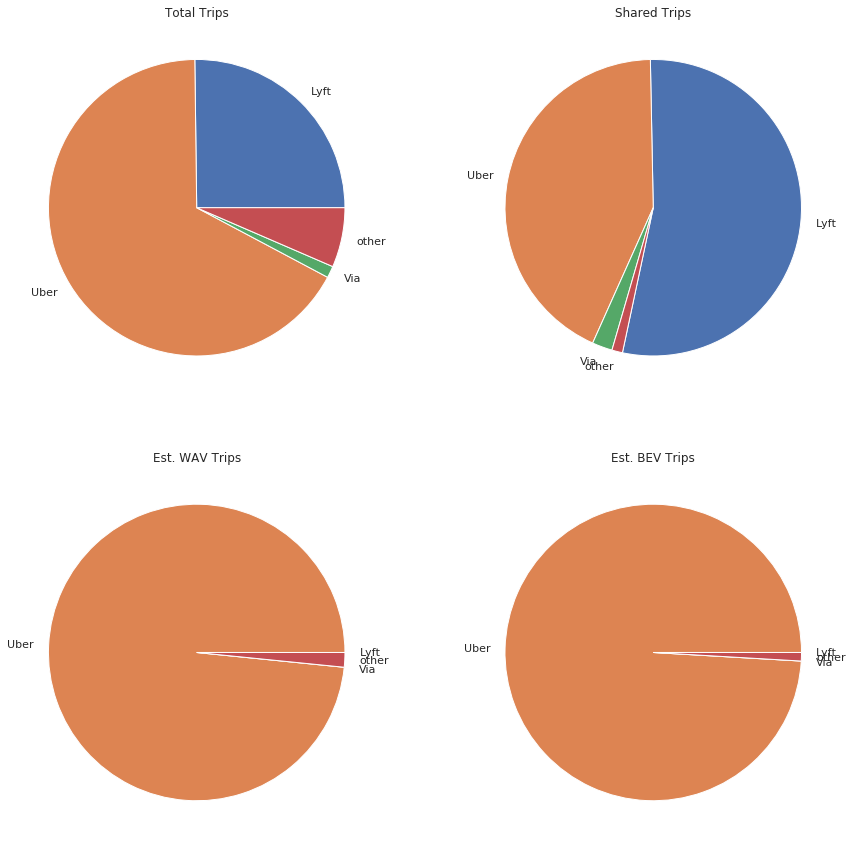

In [191]:
# Create a matplot figure with space for 4 graphs
plt.figure(figsize=(15,15))
# Size them 2 x 2
plt.subplot(2,2,1)

# Create plot 1
plt.pie(labels=week_df.index, x=week_df['trip_count'])
plt.title('Total Trips')
# Create plot 2
plt.subplot(2,2,2)
plt.pie(labels=week_df.index, x=week_df['shared'], startangle=-102)
plt.title('Shared Trips')
# Create plot 3
plt.subplot(2,2,3)
plt.pie(labels=week_df.index, x=week_df['est_WAV'])
plt.title('Est. WAV Trips')
# Create plot 4
plt.subplot(2,2,4)
plt.pie(labels=week_df.index, x=week_df['est_BEV'])
plt.title('Est. BEV Trips')

#Show plot
plt.show()

In [113]:
dispatcher_df

,dispatcher_name
B02160,other
B03135,other
B03063,other
B02834,other
B03159,other
...,...
B02882,Uber
B02866,Uber
B02877,Uber
B03036,other
